In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets, preprocessing, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

plt.style.use('ggplot')

In [2]:
# import previously cleaned data and remove unwanted column

housing = pd.read_csv('../../Machine_Learning_Project/data/Ames_HousePrice_withAddress_cleaned.csv')
housing.drop(['Unnamed: 0'], axis=1, inplace=True)


In [3]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
#dir(sklearn.ensemble)

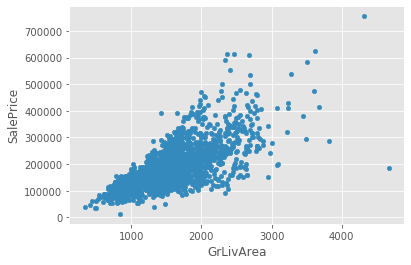

In [4]:
housing.plot.scatter(x='GrLivArea', y='SalePrice')

In [5]:
# remove apparent outliers from the above scatterplot
housing = housing[(housing['GrLivArea'] <= 4000) & (housing['SalePrice'] > 60000)]

Below we see that a linear trend is much more present when the SalePrice is on log scale.

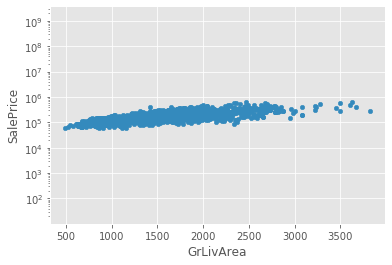

In [6]:
housing.plot.scatter(x='GrLivArea', y='SalePrice', logy=True)

In [7]:
housing.columns

Index(['GrLivArea', 'SalePrice', 'MSZoning', 'LotFrontage', 'LotArea',
       'LotShape', 'LandContour', 'LandSlope', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Fence', 'GeoRefNo', 'Prop_Addr', 'lat',
       'long', 'Baths', 'Class_1.5story', 'Class_1story_dev', 'Class_2story',
       'Class_2story_dev', 'Class_duplex', 'Class_split', 'Lot_Corner',
       'Lot_CulDSac', 'Lot_FR', 'Foundation_Concrete', 'Foundation_Other',
       'price_per_s

In [8]:
# Select what features will be used for the model 
X = housing[['GrLivArea', 'OverallQual', 'OverallCond', 
            'ExterQual', 'BsmtFinSF1', 'ScreenPorch',
            'TotalBsmtSF', 'KitchenQual', 'Fireplaces', 'GarageArea',
            'WoodDeckSF', 'MasVnrArea']].copy()

# Target variable on log scale
y = np.log(housing['SalePrice']).copy()

In [9]:
X.isna().sum()

GrLivArea      0
OverallQual    0
OverallCond    0
ExterQual      0
BsmtFinSF1     1
ScreenPorch    0
TotalBsmtSF    1
KitchenQual    0
Fireplaces     0
GarageArea     1
WoodDeckSF     0
MasVnrArea     0
dtype: int64

In [10]:
# Replace missing data within the feature variables. 
# We are operating under the assumption that the feature 
# does not exist if it is missing and thus set its value to zero.

X = X.fillna(0)

In [11]:
y.isna().sum()

0

In [12]:
# Separate the data into train and test subssets for later model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling


In [13]:
gbm = GradientBoostingRegressor()

In [14]:
gbm.set_params(learning_rate=0.03, n_estimators=1000, max_depth=2, max_features=3, subsample=.9, warm_start=False, verbose = 1)

gbm.fit(X_train,y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test, y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1334           0.0046            1.00s
         2           0.1283           0.0048            1.00s
         3           0.1223           0.0036            1.00s
         4           0.1209           0.0035            1.00s
         5           0.1150           0.0043            0.80s
         6           0.1134           0.0039            0.83s
         7           0.1104           0.0035            0.85s
         8           0.1070           0.0030            0.87s
         9           0.1031           0.0032            0.88s
        10           0.1016           0.0021            0.79s
        20           0.0758           0.0023            0.79s
        30           0.0588           0.0013            0.71s
        40           0.0463           0.0009            0.70s
        50           0.0386           0.0006            0.67s
        60           0.0324           0.0005            0.66s
       

In [15]:
gen_train = gbm.staged_predict(X_train)
gen_test  = gbm.staged_predict(X_test)

trainR2 = []
testR2  = []
steps   = range(1,1000)
for n in steps:
    y_pred_train = next(gen_train)
    y_pred_test  = next(gen_test)
    trainR2.append(r2_score(y_pred_train, y_train))
    testR2.append(r2_score(y_pred_test, y_test))

Text(0, 0.5, '$R^2$')

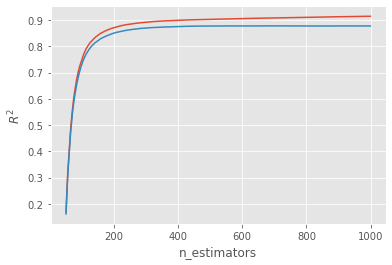

In [16]:
start = 50
end   = 1000

plt.plot(steps[start:end], trainR2[start:end],label='train')
plt.plot(steps[start:end], testR2[start:end],label='test')
plt.xlabel('n_estimators')
plt.ylabel(r'$R^2$')

In [17]:
# this cell is used for parameter tuning, commented out due to long run time

# LR = {'n_estimators':[100, 200, 300, 350, 400, 500], \
#       'max_depth':[2,3,4,5], 'max_features': [2, 3, 4, 5]}

# tuning = GridSearchCV(estimator = GradientBoostingRegressor(),
#                      param_grid = LR, scoring = 'r2')

# tuning.fit(X_train, y_train)
# tuning.best_params_, tuning.best_score_

In [18]:
gbm.set_params(learning_rate=0.03, n_estimators=333, max_depth=2, max_features=3, subsample=.9, warm_start=False)
gbm.fit(X_train, y_train)
print('-'*50)
print("The train set R^2 is %.3f" %(gbm.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(gbm.score(X_test, y_test)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1330           0.0045            0.33s
         2           0.1267           0.0050            0.33s
         3           0.1233           0.0040            0.22s
         4           0.1180           0.0042            0.25s
         5           0.1187           0.0033            0.26s
         6           0.1140           0.0033            0.27s
         7           0.1112           0.0029            0.28s
         8           0.1067           0.0032            0.24s
         9           0.1029           0.0033            0.25s
        10           0.1011           0.0028            0.26s
        20           0.0765           0.0018            0.22s
        30           0.0583           0.0016            0.20s
        40           0.0473           0.0010            0.19s
        50           0.0388           0.0007            0.18s
        60           0.0319           0.0006            0.17s
       

In [19]:
# generate a final model using the entire dataset

model = gbm.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.1313           0.0047            0.32s
         2           0.1274           0.0041            0.33s
         3           0.1227           0.0041            0.33s
         4           0.1191           0.0046            0.33s
         5           0.1158           0.0031            0.33s
         6           0.1101           0.0037            0.33s
         7           0.1068           0.0036            0.32s
         8           0.1040           0.0038            0.32s
         9           0.1030           0.0026            0.32s
        10           0.0983           0.0030            0.32s
        20           0.0739           0.0020            0.27s
        30           0.0584           0.0012            0.24s
        40           0.0464           0.0010            0.23s
        50           0.0375           0.0007            0.22s
        60           0.0320           0.0006            0.21s
       

In [20]:
gbm.score(X, y)

0.9067402095565384

In [21]:
# expect similar result to above
y_pred = model.predict(X)
r2_score(y_pred, y)

0.8929370342932627

# Feature Importance

In [22]:
importance = sorted(list(zip(X.columns, list(gbm.feature_importances_))), key=lambda t:t[1], reverse=True)

Text(0.5, 1.0, 'feature importance of a gbm classifier')

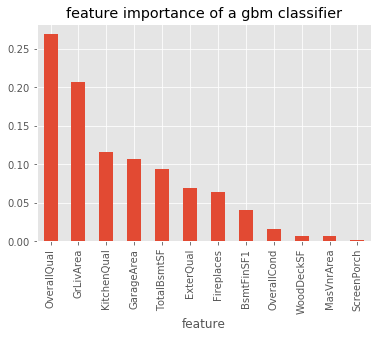

In [23]:
a, b = zip(*importance)
importance_score = pd.DataFrame({'feature':a, 'score':b})
importance_score.plot.bar(x='feature', y='score', legend=None)
plt.title('feature importance of a gbm classifier')